# Local Features
* Detection
 * Identify interesting points e.g., edges, corners, ...
* Extraction
 * Extract feature descriptor around the interest points
* Matching
 * Determine correspondence btw descriptors in two views

Extracting and matching
* approaches
 * Simple option: square window around the points
 * SOTA: **Scale Invariant Feature Transformation (SIFT)** [Lowe, 2004]
 
_Invariance_ (shouldn't change when an image is geometrically/photometrically transformed)  
vs.  
_Discriminability_ (should be highly unique for each point)

## Overview of SIFT
1. Keypoint detection
 * Scaling and keypoint detection
 * Localizing keypoints
2. Feature description
 * Computation of orientation
 * Description of features

## Keypoint Detection w/ Difference-of-Gaussian (DoG)
DoG filter behaves as an approximation of LoG filter

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

The plot below shows DoG in a 3D space

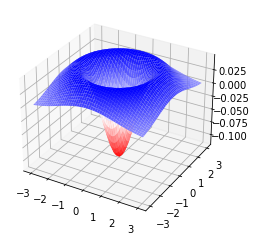

In [2]:
x = np.linspace(-3., 3., 50)
x, y = np.meshgrid(x, x)
X = np.c_[np.ravel(x), np.ravel(y)]

def f_normal_nd(x, mean, var):
    return np.exp(-.5 * np.sum(np.square(x - mean), axis=-1, keepdims=True) / var) / np.sqrt(2. * np.pi * var)

z1 = f_normal_nd(X, 0., 1.)
z1 = z1.reshape(x.shape)

z2 = f_normal_nd(X, 0., 2.)
z2 = z2.reshape(x.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(x, y, z2 - z1, cmap="bwr_r")

First, define efficient Gaussian filter ($\mathcal{O}(HWK)$)

In [3]:
def conv1d(image, kernel, axis):
    assert kernel.shape[0] % 2 == 1
    assert axis == 0 or axis == 1
    # assert grayscale
    assert image.ndim == 2
    
    # axis = 1 is equivalent to axis = 0 with transposed image
    if axis == 1:
        image = np.transpose(image, [1, 0])
        
    kdiv2 = kernel.shape[0] // 2
    h, w = image.shape
    
    # padding
    padded = np.empty((h + 2 * kdiv2, w), dtype="float32")
    padded[kdiv2:-kdiv2, :] = image
    for i in range(kdiv2):
        padded[i, :]  = image[ 0, :]
        padded[-(i + 1), :] = image[-1, :]
        
    # convolution
    result = np.zeros_like(image)
    for i in range(h):
        for j in range(w):
            for k in range(kernel.shape[0]):
                result[i, j] += kernel[k] * padded[i + k, j]
    
    # re-transpose
    if axis == 1:
        image = np.transpose(image, [1, 0])  # check later
        result = np.transpose(result, [1, 0])
    
    return result

def gaussian1d(x, var):
    # mean = 0
    return np.exp(-.5 * x * x / var) / np.sqrt(2. * np.pi * var)

def gaussian_filter(image, var, kernel_size):
    assert var > 0.
    assert kernel_size % 2 == 1
    
    # create kernel
    kernel = np.empty((kernel_size, ))
    for i in range(kernel_size):
        kernel[i] = gaussian1d(i - kernel_size // 2, var)
    # normalize
    kernel = kernel / np.sum(kernel)
    
    # apply the kernel
    result = np.empty_like(image)
    result = conv1d(image, kernel, axis=0)
    result = conv1d(image, kernel, axis=1)
    return result

Using this Gaussian filter, visualize DoG

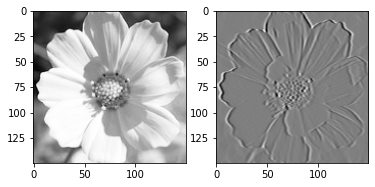

In [4]:
from PIL import Image
img = Image.open("img/flower.jpg") # https://www.flickr.com/photos/tanaka_juuyoh/2606431115/
# convert to grayscale
img = img.convert("L")
img = np.asarray(img).astype("float32") / 255.

# apply DoG filter
dogs = [gaussian_filter(img, float(i + 1), 7) for i in range(2)]
# compute difference
diff = dogs[1] - dogs[0]
# normalize
diff = (diff - np.min(diff)) / (np.max(diff) - np.min(diff))
# show image
plt.subplot(121)
plt.imshow(img, cmap="Greys_r")
plt.subplot(122)
plt.imshow(diff, cmap="Greys_r")

SIFT requires applying many gaussian filters with their variances varying, which is computationally heavy. To reduce the cost, SIFT uses pyramid representation to get DoG function $D(x, y, \sigma)$.

In [5]:
def down_sample(image):
    h, w = image.shape
    result = np.zeros((h // 2, w // 2))
    for i in range(h // 2):
        for j in range(w // 2):
            result[i, j] = np.mean(image[i*2:(i+1)*2, j*2:(j+1)*2])
    return result

def get_keypoints(image, octaves):
    # return filtered images and its scale (size)
    scale = 1
    filtered = [gaussian_filter(image, float(scale), 7)]
    scales = [scale]
    sampled = image
    for i in range(octaves):
        # down sampling
        sampled = down_sample(sampled)
        scale = scale * 2
        filtered.append(gaussian_filter(sampled, float(scale), 7))
        scales.append(scale)
    return filtered, scales

In [ ]:
imgs, sc = get_keypoints(img, 3)
print(sc)
for i, im in enumerate(imgs):
    plt.subplot(1, len(imgs), i+1)
    plt.imshow(im, cmap="Greys_r")

When a key point is in a small image, it means that the key point has a large scale.

## Localizing Keypoints